In [1]:
from itertools import product, permutations
from functools import reduce
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot,
    labs,
    theme_minimal,
    theme_linedraw,
    geom_dotplot,
    scale_fill_brewer
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [2]:
from torch.nn.functional import relu
from copy import deepcopy

def fp_sort_key(fp):
    last_part = fp.parts[-1].strip('.pth')
    if last_part == 'full_run':
        return 2 ** 10000
    else:
        return int(last_part)


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def if_then(pred, x0, x1):
    return pl.when(pred).then(pl.lit(x0)).otherwise(pl.lit(x1))


def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


def fourier_stats(model_seed, ckpt_path):
    #ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    ckpt_dir = Path(ckpt_path)
    run_name = f's5_40_{model_seed}'
    S5 = Symmetric(5)

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    config = model_run['config']
    embed_dim = config['embed_dim']

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    unembed_power_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df, unembed_power_df], how='vertical').melt(id_vars=['layer', 'irrep'])
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    unembed_decomp = sn_fourier_basis(unembed_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    unembed_df = fourier_basis_to_df(unembed_decomp, 5, 'unembed')
        
    
    return llinear_df, rlinear_df, unembed_df, power_df 


def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    

In [3]:
a5_subgroups = {
    "order": 60,
    "copies": 1,
    "generators": [[(4, 0, 1, 2, 3), (2, 0, 1, 3, 4)]]
}

s4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}



In [4]:
def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, index, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': f'{sg_name}_{index}', f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return pl.concat(data, how='vertical')


def make_right_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return pl.concat(data, how='vertical')



def make_right_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


def make_left_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


In [5]:
your_path = '/Users/dashiell/workspace/sn-grok/s5_40_small'

llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(5, your_path)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
linear_df = get_linear_layer_decomp(5)

In [6]:
all_s4 = [generate_subgroup(gens) for gens in s4_subgroups['generators']] 
all_a5 = [generate_subgroup(gens) for gens in a5_subgroups['generators']]


s4_left_coset_df = make_left_coset_rep_df(all_s4, 5, 's4')
s4_right_coset_df = make_right_coset_rep_df(all_s4, 5, 's4')

a5_coset_df = make_left_coset_rep_df(all_a5, 5, 'a5')


## Sign Circuit Graphs

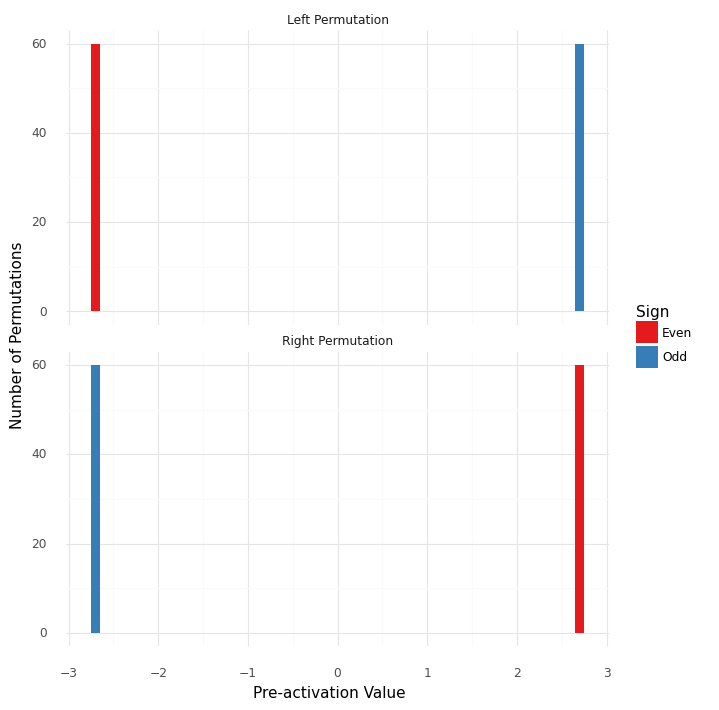

<ggplot: (688097262)>

In [40]:
dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(a5_coset_df, on='permutation')
    .with_columns(if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(a5_right_coset_df, on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')


fig = (
    ggplot(df, aes(x='value', fill='sign')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Sign")
    + theme_minimal()
    + theme(figure_size=(7,8))
    + scale_fill_brewer('qual', 6)
)
fig

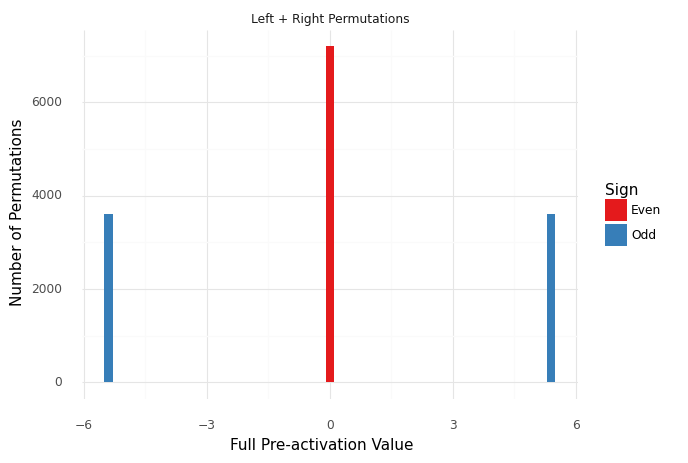

<ggplot: (688086545)>

In [41]:
dflin = (
    linear_df
    .select(['permutation_target', 'dim16'])
    .join(a5_coset_df, left_on='permutation_target', right_on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400)
    )
)

fig = (
    ggplot(dflin, aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Sign")
    + theme_minimal()
    + scale_fill_brewer('qual', 6)
)
fig

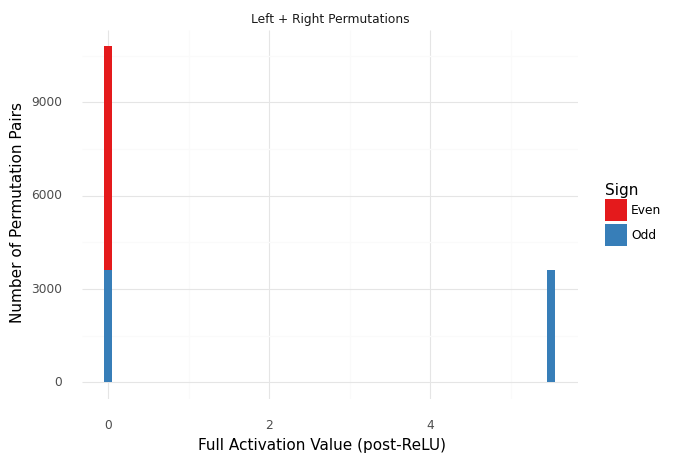

<ggplot: (688185299)>

In [42]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim16').clip_min(0)), aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutation Pairs", x = "Full Activation Value (post-ReLU)", fill="Sign")
    + theme_minimal()
    + scale_fill_brewer('qual', 6)
)
fig

## S_4 Circuit Graphs

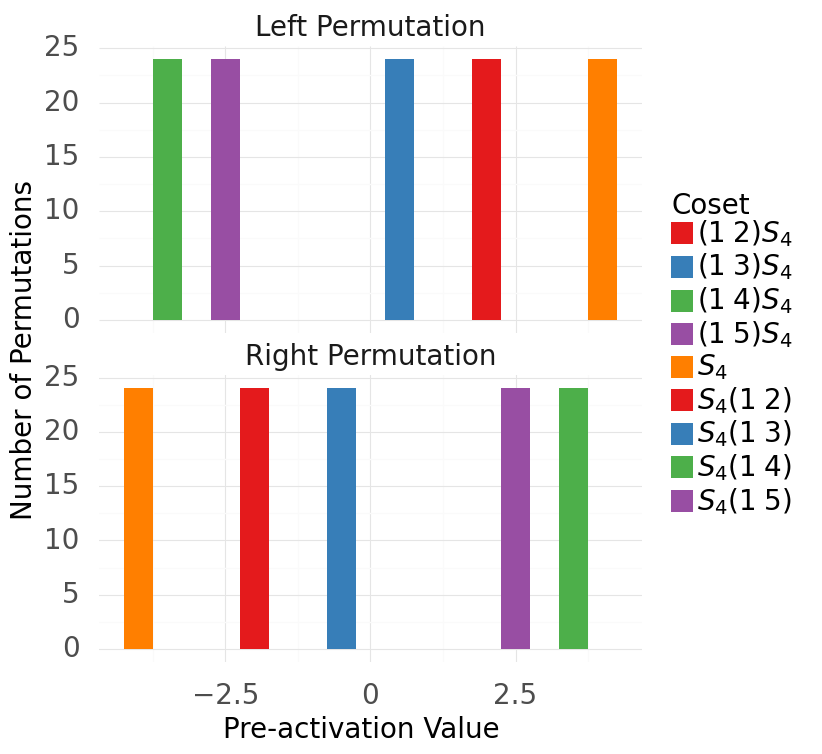

<ggplot: (685247062)>

In [19]:
from mizani.palettes import brewer_pal
from plotnine import scale_fill_manual, element_text



left_coset_rename = {
    '(0, 1, 2, 3, 4)': '$S_4$',
    '(1, 0, 2, 3, 4)': '$(1\;2)S_4$',
    '(1, 2, 0, 3, 4)': '$(1\;3)S_4$',
    '(1, 2, 3, 0, 4)': '$(1\;4)S_4$',
    '(1, 2, 3, 4, 0)': '$(1\;5)S_4$',

}

right_coset_rename = {
    '(0, 1, 2, 3, 4)': '$S_4$',
    '(1, 0, 2, 3, 4)': '$S_{4}(1\;2)$',
    '(2, 0, 1, 3, 4)': '$S_{4}(1\;3)$',
    '(3, 0, 1, 2, 4)': '$S_{4}(1\;4)$',
    '(4, 0, 1, 2, 3)': '$S_{4}(1\;5)$'

}


dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(s4_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(right_coset_rename))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(left_coset_rename))
    
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')

palette = brewer_pal('qual', 6)(5)

colors = palette + palette[:-1]


fig = (
    ggplot(df, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.5) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    + theme_minimal()
    + theme(figure_size=(7,8), text=element_text(size=20))
    + scale_fill_manual(values = colors)
)

fig

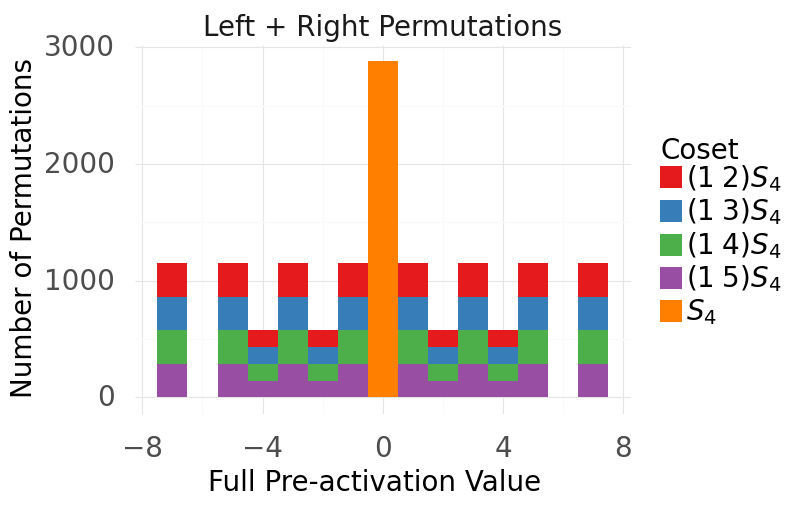

<ggplot: (686810070)>

In [23]:

dflin = (
    linear_df
    .select(['permutation_target', 'dim23'])
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col('coset_rep').map_dict(left_coset_rename)
    )
)

fig = (
    ggplot(dflin, aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Coset")
    + theme_minimal()
    + theme(text=element_text(size=20))
    + scale_fill_brewer(type='qual', palette=6)
)
fig

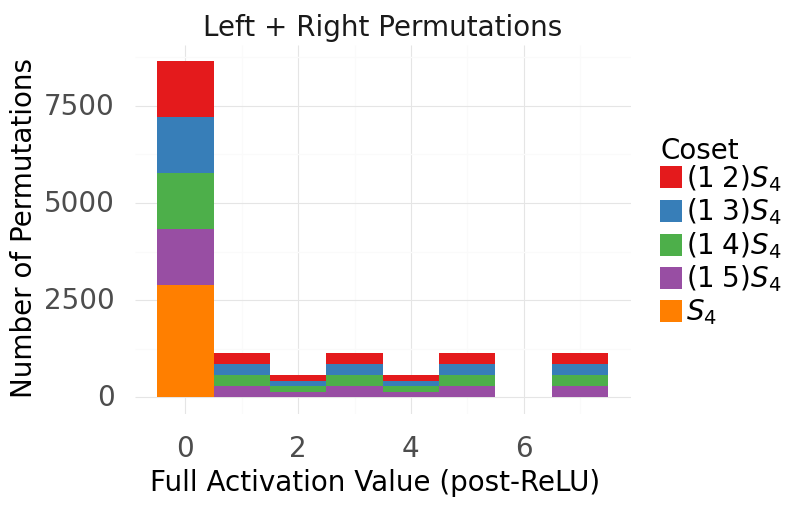

<ggplot: (687083202)>

In [27]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim23').clip_min(0)), aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=1
)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Activation Value (post-ReLU)", fill="Coset")
    + theme_minimal()
    + theme(text=element_text(size=20))
    +  scale_fill_brewer(type='qual', palette=6)
)
fig

## Unembed Correlation Graph

In [4]:
from plotnine import scale_fill_continuous, scale_x_discrete, scale_y_discrete, coord_trans, scale_fill_brewer, labs
merged_df = pl.read_parquet('s5_small_coset_stats.parquet')
lr_df = pl.read_parquet('s5_small_left_right_cosets.parquet')

In [5]:
subgroup_counts = (
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .groupby('subgroup_pair').count()
    .sort('count')
)

unembed_cols = (
    merged_df
    
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .filter(pl.col('seed') == 5)
    .join(subgroup_counts, on='subgroup_pair')
    .sort(['count', 'subgroup_pair', 'variable'])
    .select('variable')
)['variable'].to_list()

In [12]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(5, your_path)

unembed_base = (
    unembed_df
    .select(pl.exclude('irrep'))
    .groupby(['layer', 'permutation']).sum()
)

In [13]:
coset_pairs = (
    merged_df
    .filter((pl.col('left_coset_var_ratio') < 1.0) & (pl.col('right_coset_var_ratio') < 1.0) & (pl.col('epoch') == 249999))
    .filter(pl.col('seed') == 5)
    .select(['variable', 'subgroup_pair'])
)
corrs = unembed_base.select(unembed_cols).corr()
corrs.insert_at_idx(0, pl.Series('left_cols', unembed_cols))
corr_df = corrs.melt(id_vars='left_cols', variable_name='right_cols')
corr_df = corr_df.join(coset_pairs, left_on='left_cols', right_on='variable').rename({'subgroup_pair': 'left_coset'})
corr_df = corr_df.join(coset_pairs, left_on='right_cols', right_on='variable').rename({'subgroup_pair': 'right_coset'})


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: unembed_corr_seed5.pdf


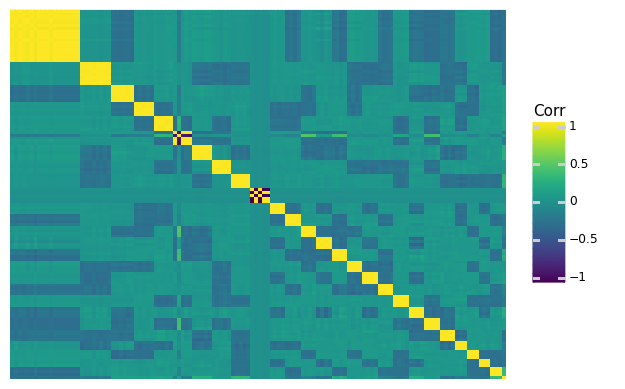

<ggplot: (707210688)>

In [19]:
from plotnine import element_blank

fig = (
    ggplot(corr_df, aes(x='left_cols', y='right_cols', fill='value')) 
    + geom_tile() 
    + scale_x_discrete(limits=unembed_cols[::-1], labels=[])
    + scale_y_discrete(limits=unembed_cols, labels=[])
    + scale_fill_continuous(limits=[-1, 1])
    + labs(fill='Corr', x='', y='')
    + theme(axis_ticks=element_blank())
)
fig.save('unembed_corr_seed5.pdf')
fig

## Logit Constructive Interference Boxplot

In [20]:
model_seed = 5
your_path = '/Users/dashiell/workspace/sn-grok/s5_40_small'
ckpt_dir = Path(your_path)
run_name = f's5_40_{model_seed}'

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

#full_left_coset_df, full_right_coset_df = make_full_coset_df()

checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)

model = SnMLP.from_config(full_run['config'])
model.load_state_dict(full_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']

In [23]:
cols = [23, 42, 51, 126]

def get_s4_coset(col_name, element):
    new_val = {
        0: 'S4',
        1: '(1 2)S4',
        2: '(1 3)S4',
        3: '(1 4)S4',
        4: '(1 5)S4',
        
    }
    return (
        pl.col(col_name)
        .str.extract_all('([0-4])')
        .list.eval((pl.element() == element).cast(pl.UInt32))
        .list.arg_max().map_dict(new_val)
    )


logits1 = (model.unembed.weight[:, cols[0]].unsqueeze(1) @ relu(linear_acts[:, cols[0]].T).unsqueeze(0)).T.detach().numpy()
logits2 = (model.unembed.weight[:, cols[0:2]] @ relu(linear_acts[:, cols[0:2]].T)).T.detach().numpy()
logits4= (model.unembed.weight[:, cols] @ relu(linear_acts[:, cols].T)).T.detach().numpy()
sn_df = run_data.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
full_group = Permutation.full_group(5)
logit1_df = pl.concat(
    [sn_df, pl.DataFrame(logits1, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logit2_df = pl.concat(
    [sn_df, pl.DataFrame(logits2, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logit4_df = pl.concat(
    [sn_df, pl.DataFrame(logits4, schema=[str(p) for p in full_group])],
    how='horizontal'
)

In [24]:
df1 = (
    logit1_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit')
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)

df1.insert_at_idx(0, pl.Series('neurons', ['1 S4 Neuron'] * df1.shape[0]))

df2 = (
    logit2_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit'),
        pl.Series('neurons', ['One S4 Neuron'])
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)
df2.insert_at_idx(0, pl.Series('neurons', ['2 S4 Neurons'] * df2.shape[0]))
                  
df4 = (
    logit4_df
    .with_columns(get_s4_coset('permutation_target', '0').alias('coset_target'))
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_target'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .with_columns([
        get_s4_coset('permutation_logit', '0').alias('coset_logit')
        
    ])
    .filter(pl.col('coset_target') != 'S4')
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])  
)  
df4.insert_at_idx(0, pl.Series('neurons', ['4 S4 Neurons'] * df4.shape[0]))
df = pl.concat([df1, df2, df4])

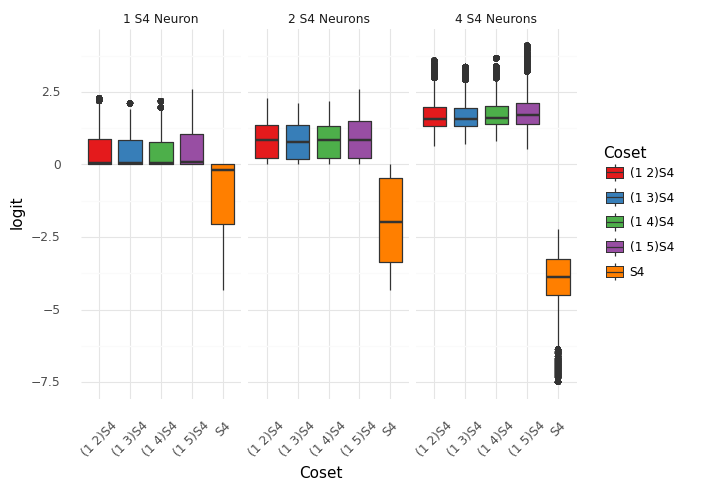

<ggplot: (707163022)>

In [25]:
from plotnine import scale_y_log10, theme_minimal, geom_violin, geom_density, scale_color_brewer
fig = (
    ggplot(df, aes(x='coset_logit', y='logit', fill='coset_logit')) 
    + geom_boxplot()
    + facet_wrap('~neurons')
    + theme_minimal()
    + scale_fill_brewer(type='qual', palette=6)
    + theme(axis_text_x=element_text(angle=45))
    + labs(x = 'Coset', fill='Coset')
)
#fig.save('logit_constructive_interference_boxplot.pdf')
fig

## Fourier Entropy Plot

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: s5_40_fourier_entropy.pdf


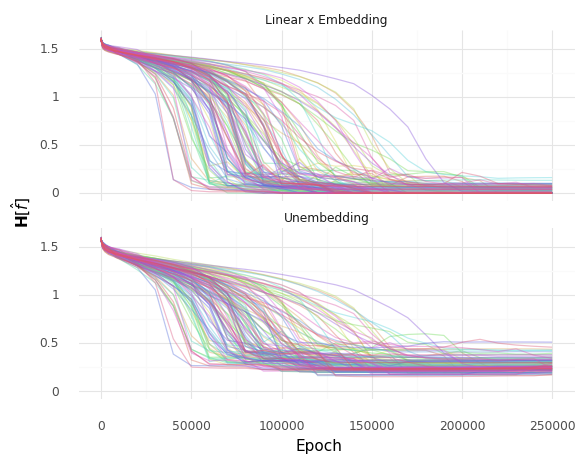

<ggplot: (680502074)>

In [28]:
from plotnine import scale_color_hue

all_entropy_df = pl.read_parquet('s5_40_small_fourier_entropy.parquet')

layer_rename = {
    'left_embed': 'Embedding',
    'right_embed': 'Embedding',
    'left_linear': 'Linear x Embedding',
    'right_linear': 'Linear x Embedding',
    'unembed': 'Unembedding'

}


df = (
    all_entropy_df
    
    .filter(pl.col('layer').is_in(['unembed', 'left_linear', 'right_linear']))
    .with_columns([
        pl.col('layer').map_dict(layer_rename),
        pl.col('fourier_entropy').fill_nan(0)
    ])
    .sort(['seed', 'epoch', 'dim']).groupby(['seed', 'epoch', 'layer']).agg([
        pl.col('fourier_entropy').mean(),
        pl.col('l1').mean(),
        pl.col('l2').mean()
    ])
)


fig = (
    ggplot(df, aes(x='epoch', y='fourier_entropy', color='factor(seed)')) 
    + geom_line(alpha=0.4, show_legend=False)
    + labs(x='Epoch', y='$\\mathbf{H}[\\hat{f}]$')
    + theme_minimal()
    + facet_wrap('~layer', nrow=2)
    + scale_color_hue()
   #+ theme(axis_text_x=element_text(angle=45))
)
#fig.save('s5_40_fourier_entropy.pdf')
fig